In [103]:
import os, sys
import matplotlib.pyplot as plt 
import seaborn
import matplotlib
import numpy as np 
import math 
import matplotlib
import pandas as pd
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


color_list = [
            'tab:blue',
            'tab:orange',
            'tab:green',
            'tab:red',
            'tab:purple',
            'tab:brown',
            'tab:pink',
            'tab:gray',
            'tab:olive',
            'tab:cyan']

hatch_list = [
    '', 
    '/', 
    '\\',
    '*', 
    '///',
    '+', 
    '--', 
    'x',

    '*', 

    'O', 
    
]

line_style_list = [
    '-', 
    '--', 
    '-.', 

]

marker_list = [
    '',
    'o', 
    'v',
    '^', 
    'X', 
    'D'
    's', 
]

template = {
    'fontsize': 18, 
    'linewidth': 6, 
    'scatter_markersize': 400, 
    'line_markersize': 20, 
    'width': 0.5, 
}

def autolabel_percent(rects, ax, value_list, error_list=None, str_func=None):
    if str_func is None: 
        str_func = lambda x: '%.2f'%(x)

    if error_list is None: 
        error_list = [0 for _ in value_list]

    for idx, rect in enumerate(rects):
        if value_list[idx] is None: continue
        height = rect.get_height()
        ax.annotate(str_func(value_list[idx]),
                    xy=(rect.get_x() + rect.get_width() / 2, height+error_list[idx]),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=16, fontweight='bold')


def check_before_run(**kwargs): 
    if   kwargs['full'] + kwargs['half'] + kwargs['forth'] > 1: 
        return False 
    return True 


def apply_grid(ax, **kwargs): 
    if kwargs.get('grid'): 
        if not (kwargs.get('ygrid') or kwargs.get('xgrid')): 
            ax.grid(linestyle='-.', linewidth=1, alpha=0.5)

    if kwargs.get('ygrid'): 
        ax.grid(linestyle='-.', linewidth=1, alpha=0.5, axis='y')
    if kwargs.get('xgrid'): 
        ax.grid(linestyle='-.', linewidth=1, alpha=0.5, axis='x')


def apply_spine(ax, **kwargs): 
    if kwargs.get('spines'): 
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')


def apply_font(kwargs): 
    font = {'family' : 'serif',
            'size'   : 18}
    if kwargs.get('font'): 
        font.update(kwargs.get('font'))
    matplotlib.rc('font', **font)


def apply_log(ax, **kwargs): 
    if kwargs.get('logx') > 0: 
        ax.set_xscale('log', basex=kwargs.get('logx'))
    if kwargs.get('logy') > 0: 
        ax.set_yscale('log', basey=kwargs.get('logy'))

def init_plot(ncols, **kwargs): 
    # if len(kwargs) > 0: 
    #     assert check_before_run(kwargs)
    
    apply_font(kwargs)
    if isinstance(ncols, tuple): 
        fig, axes = matplotlib.pyplot.subplots(ncols[0], ncols[1])
        fig.set_size_inches(w=ncols[1]* 4, h=3*ncols[0])
        axes = [ax for ax in axes.flatten()]
        # axes = [axes[j][i] for i in range(ncols[0]) for j in range(ncols[1])]
        # import pdb; pdb.set_trace() 
    else: 
        fig, axes = matplotlib.pyplot.subplots(1, ncols)
        if ncols == 1: 
            axes = [axes]
        fig.set_size_inches(w=ncols* 4, h=3)
    for ax in axes: 
        apply_grid(ax, **kwargs)
        apply_spine(ax, **kwargs)
        apply_log(ax, **kwargs)

    return fig, axes 


In [104]:
## prepare

In [105]:
def cal_jct(df): 
    num_job = 1.0 * len(df)
    jct = 0
    min_time = sys.maxsize
    max_time = 0
    jct_list = list() 
    for idx, job in df.iterrows(): 
        jct += (job.completion_time - job.submission_time) / num_job
        min_time = min(job.submission_time, min_time)
        max_time = max(job.completion_time, max_time)
        jct_list.append((job.completion_time - job.submission_time))
    return jct, max(jct_list) # max_time - min_time

def cal_fft(df): 
    unfairs = 0 
    for idx, job in df.iterrows(): 
        if job.finish_time_fairness > 1: 
            unfairs += 1
    num_job = len(df)
    return unfairs / num_job

In [106]:
if True:
    import glob 
    model_name_list = ['roberta-base', 'vit', 'vit-large', 'roberta-large']
    
    log_info = ''
    info_by_method_dict = dict() 
    fairness_info_by_method_dict = dict() 
    makespan_info_by_method_dict = dict()
    for model_name in model_name_list:
        info_by_method = list() # ('titan', '-True'), 
        fairness_info_by_method = list() 
        makespan_info_by_method = list() 
        
        # for (schedule, sched_verbose) in [('titan', '-True-True'), ('optimus', ''), ('themis', ''), ('tiresias', '')]: # , ('pollux', '')]: ('srtf', ''), ('gavel', ''),
        # for (schedule, sched_verbose) in [('titan', '-False-True'), ('pollux', ''), ('optimus', ''), ('themis', ''), ('srtf', ''),  ('tiresias', '')]:
        for (schedule, sched_verbose) in [('titan', '-True-True'),  ('optimus', ''), ('pollux', ''), ('themis', ''), ('srtf', ''),  ('tiresias', '')]:
            jct_list = list() 
            fairness_list = list() 
            makespan_list = list() 
            for trace_path in sorted(glob.glob('../trace/main/FM-*')): 
                if os.path.isdir(trace_path) and trace_path.endswith(model_name): 
                    trace_ident = os.path.basename(trace_path)
                    # if schedule == 'titan': 
                    trace_ident = trace_ident + sched_verbose
                    csv_name = os.path.join('../result/main/', schedule, trace_ident, '{}.csv'.format(schedule))
                    df = pd.read_csv(csv_name)
                    jct, makespan = cal_jct(df)
                    jct_list.append(jct / 3600)
                    makespan_list.append(makespan / 3600)
                    if 'titan' in schedule: 
                        log_info = log_info + ('schedule {}, trace {}, jct {} hours\n'.format(schedule, trace_ident, jct/3600))
                    csv_name = os.path.join('../result/main', schedule, trace_ident, '{}_fairness.csv'.format(schedule))
                    df = pd.read_csv(csv_name) 
                    fairness = cal_fft(df)
                    fairness_list.append(fairness)

            sched_verbose = ''
            info_by_method.append([schedule + sched_verbose, jct_list, [0 for jct in jct_list]])
            makespan_info_by_method.append([schedule + sched_verbose, makespan_list, [0 for jct in jct_list]])
            if schedule in ['titan', 'pollux', 'gavel', 'themis']: 
                fairness_info_by_method.append([schedule + sched_verbose, fairness_list, [0 for fairness in fairness_list]])
        info_by_method_dict[model_name] = info_by_method
        fairness_info_by_method_dict[model_name] = fairness_info_by_method
        makespan_info_by_method_dict[model_name] = makespan_info_by_method
        template.update(
            {
                "norm": False, 
                "width": 0.5, 
                "autolabel": False, 
                'norm': True,
                'logy': -1,
                'logx':2,
                'barh': True,
            }
        )
        

In [107]:
info_by_method

[['titan',
  [0.14717575863776397, 0.18447417746944195, 0.1455335846775111],
  [0, 0, 0]],
 ['optimus',
  [0.34304538040470195, 0.4841815351689305, 0.7788710383143689],
  [0, 0, 0]],
 ['pollux',
  [0.36959695515809243, 0.4796190826642662, 0.7130840042619793],
  [0, 0, 0]],
 ['themis',
  [0.45218396101174524, 0.6372780968142144, 0.8290959980487822],
  [0, 0, 0]],
 ['srtf',
  [0.49190155360433785, 0.7411608128635973, 0.9049247017524864],
  [0, 0, 0]],
 ['tiresias',
  [0.4974571091598934, 0.7138370793351422, 0.9293287903324328],
  [0, 0, 0]]]

In [108]:

def plot_bar_by_method(ax, info_by_method, **kwargs): 
    width = kwargs.get('width', 0.4)
#     print('width == {}'.format(width))
    interval = int(math.ceil(width * len(info_by_method) * 1.2))
    if kwargs.get('norm'): 
        norm_list = list() 
    
    for idx, (ident, y_list, error_list) in enumerate(info_by_method): 
        x_list = list() 
        base = width * ( (len(info_by_method) - 1) // 4 + 0.5 * (len(info_by_method) - 1) % 2 ) + idx * width
        # print("base =={}, lenth == {}, idx == {}".format(base, len(info_by_method), idx))
        value_list = list() 
        for idy, y in enumerate(y_list): 
            x_list.append(base + idy * interval)
            value_list.append(y)


        if kwargs.get('norm'): 
            if len(norm_list) > 0: 
                print(ident)
                print(norm_list, len(norm_list))
                print(value_list, len(value_list))

            if len(norm_list) == 0: 
                norm_list = [val for val in value_list]
                value_list = [1. for _ in value_list]
            else: 
                value_list = [val / norm for val, norm in zip(value_list, norm_list)]
                # import pdb; pdb.set_trace() 
        # import pdb; pdb.set_trace() 
        if error_list is None: 
            error_list = [0 for _ in y_list]
        
        def cap(value): 
            return value 
        value_list = [cap(value) for value in  value_list]
        
        if kwargs.get('barh', False) == True: 
            if kwargs.get('disable_legend'): 
                rect = ax.barh(x_list, value_list, xerr=error_list, height=width, color=color_list[idx], hatch=hatch_list[idx], alpha=0.75, edgecolor='black', capsize=0)
            else:
                rect = ax.barh(x_list, value_list, xerr=error_list, height=width, color=color_list[idx], hatch=hatch_list[idx], alpha=0.75, edgecolor='black', capsize=0, label=ident)
        else:
            rect = ax.bar(x_list, value_list, yerr=error_list, width=width, color=color_list[idx], hatch=hatch_list[0], alpha=0.75, edgecolor='black', capsize=0, label=ident) 

        print('x_list', x_list)    
        # print('y_list', y_list)
        if kwargs.get('autolabel'): 
            #autolabel_percent(rects, ax, value_list, error_list=None, str_func=None):
            str_func = None 
            if kwargs.get('norm'): 
                str_func = lambda x: '%.2f'%(x)
            elif 'int' in str(type(y_list[0])):
                str_func = lambda x: '%d'%(x)
            print('value_list {}'.format(value_list))
            # autolabel_percent(rect, ax, value_list, error_list=error_list, str_func=str_func)

# Makespan plot

/tmp/ipykernel_65656/2207244260.py:116: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=kwargs.get('logx'))


x_list [2.25, 13.25, 24.25]
x_list [3.75, 14.75, 25.75]
x_list [5.25, 16.25, 27.25]
x_list [6.75, 17.75, 28.75]
x_list [8.25, 19.25, 30.25]
x_list [9.75, 20.75, 31.75]
x_list [2.25, 13.25, 24.25]
x_list [3.75, 14.75, 25.75]
x_list [5.25, 16.25, 27.25]
x_list [6.75, 17.75, 28.75]
x_list [8.25, 19.25, 30.25]
x_list [9.75, 20.75, 31.75]
x_list [2.25, 13.25, 24.25]
x_list [3.75, 14.75, 25.75]
x_list [5.25, 16.25, 27.25]
x_list [6.75, 17.75, 28.75]
x_list [8.25, 19.25, 30.25]
x_list [9.75, 20.75, 31.75]
x_list [2.25, 13.25, 24.25]
x_list [3.75, 14.75, 25.75]
x_list [5.25, 16.25, 27.25]
x_list [6.75, 17.75, 28.75]
x_list [8.25, 19.25, 30.25]
x_list [9.75, 20.75, 31.75]


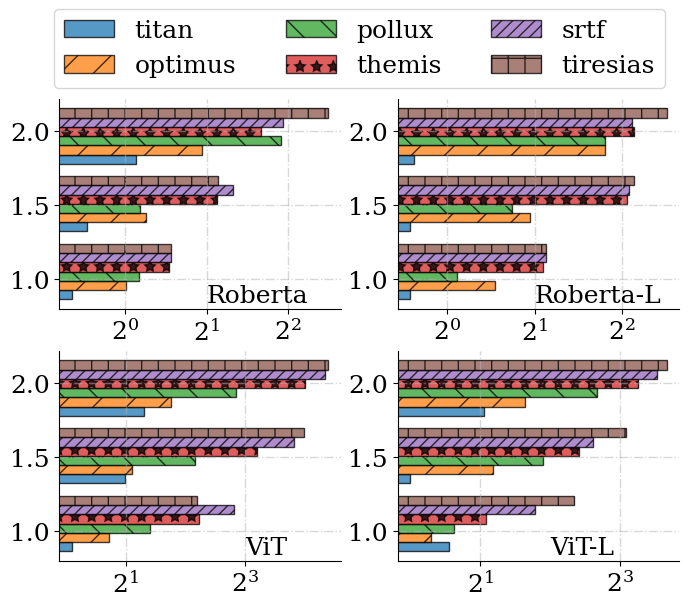

In [121]:
if True:
    template.update(
        {
            "logy": 0,
            "logx": 2,
        }
    )
    fig, axes = init_plot((2,2), grid=True, logy=template.get('logy', 0), logx=template.get('logx',0))
    model_others_list = ['Roberta', 'Roberta-L', 'ViT', 'ViT-L']
    model_name_list = ['roberta-base', 'roberta-large', 'vit', 'vit-large']
    for model_id, model_name in enumerate(model_name_list): 
#     for ax in axes: 
        ax = axes[model_id]
        x_list = [i for i in range(10)]
        y_list = [np.random.randn(1) for x in x_list]
        # ax.plot(x_list, y_list, linestyle=line_style_list[1], linewidth=template['linewidth'], color=color_list[0], \
        #     marker=marker_list[3], markersize=template['line_markersize'], markerfacecolor=color_list[1], markeredgecolor=color_list[1])
        # ax.scatter(x_list, y_list, marker=marker_list[2], s=template['scatter_markersize'])
        # info_by_method = [
        #     ['Tiresias',[1.75, 1.67, 2.87, 4.57], [0, 0, 0, 0] ],
        #     ['SRTF ', [1.74, 1.68, 1.99, 3.02], [0, 0, 0, 0] ], 
        #     ['Titan', [0.89, 1.04, 1.44, 1.88], [0, 0, 0, 0]]
        # ]



        template.update(
            {
                "norm": False, 
                "width": 1.5,
                "disable_legend": model_id!=0,
            }
        )
        plot_bar_by_method(ax, makespan_info_by_method_dict[model_name], **template)
        # ax.set_xlim(-0.5, 4)
        # ax.set_ylim(0, 1, 2)
        # ax.set_ylabel('Avg. JCT (Hour)', fontsize=template['fontsize'])
        # import pdb; pdb.set_trace() 
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # axes_list = [1.2, 3.2, 5.2, 7.2]
#         ax.set_xlabel(model_others_list[model_id], fontsize=template['fontsize'])
        text_delta = 0 if 'Roberta' in model_others_list[model_id] else 5
#         print('xlim', ax.get_xlim())
#         ax.annotate( 0.1, 0.7, model_others_list[model_id], fontsize=template['fontsize'], horizontalalignment='center')
        lo, hi = ax.get_xlim()
        ax.annotate(model_others_list[model_id], (hi//3, 1), fontsize=template['fontsize'])
        axes_list = [5.25, 17.25, 29.25]
        delta =0.5
        ax.set_yticks([val - delta for val in axes_list])
        ax.set_yticklabels(['1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
        if model_id == 0: 
            if False: 
                
                ax.set_xticks([val + 0.5 for val in axes_list])
                ax.set_xticklabels(['0.5', '1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
            else: 
                
                ax.set_yticks([val -delta for val in axes_list])
                ax.set_yticklabels(['1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
#             ax.set_ylabel('Relative Workload Density', fontsize=template['fontsize'])
#     plt.legend() 
#     plt.savefig('images/e2e/makespan.jpg',  bbox_inches='tight') 
    plt.savefig('images/e2e/makespan.pdf',  bbox_inches='tight') 
    fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
#     width * ( (len(info_by_method) - 1) // 4 + 0.5 * (len(info_by_method) - 1) % 2 ) + idx * width
    # fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=3, bbox_to_anchor=(0.55, 1.05), fancybox=True, shadow=False) 
    plt.show()

# Fairness Fraction

x_list [1.5, 7.5, 13.5]
x_list [3.0, 9.0, 15.0]
x_list [4.5, 10.5, 16.5]
x_list [1.5, 7.5, 13.5]
x_list [3.0, 9.0, 15.0]
x_list [4.5, 10.5, 16.5]
x_list [1.5, 7.5, 13.5]
x_list [3.0, 9.0, 15.0]
x_list [4.5, 10.5, 16.5]
x_list [1.5, 7.5, 13.5]
x_list [3.0, 9.0, 15.0]
x_list [4.5, 10.5, 16.5]


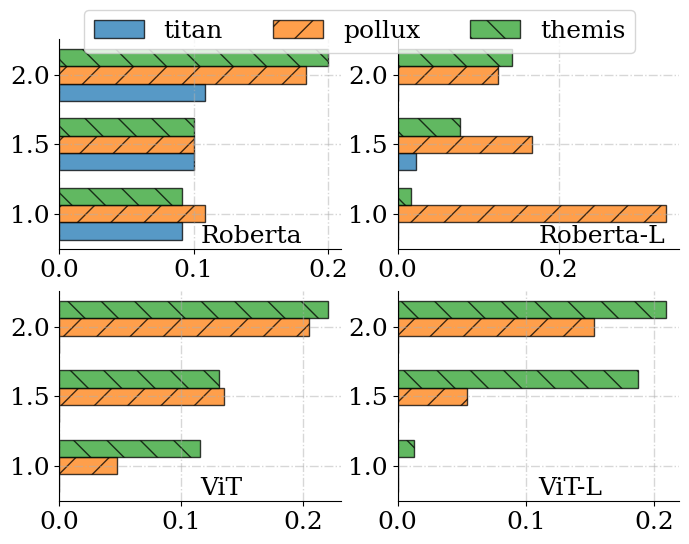

In [127]:
if True:
    template.update(
        {
            "logy": 0,
            "logx": 0,
        }
    )
    fig, axes = init_plot((2,2), grid=True, logy=template.get('logy', 0), logx=template.get('logx',0))
    model_others_list = ['Roberta', 'Roberta-L', 'ViT', 'ViT-L']
    model_name_list = ['roberta-base', 'roberta-large', 'vit', 'vit-large']
    for model_id, model_name in enumerate(model_name_list): 
#     for ax in axes: 
        ax = axes[model_id]
        x_list = [i for i in range(10)]
        y_list = [np.random.randn(1) for x in x_list]
        # ax.plot(x_list, y_list, linestyle=line_style_list[1], linewidth=template['linewidth'], color=color_list[0], \
        #     marker=marker_list[3], markersize=template['line_markersize'], markerfacecolor=color_list[1], markeredgecolor=color_list[1])
        # ax.scatter(x_list, y_list, marker=marker_list[2], s=template['scatter_markersize'])
        # info_by_method = [
        #     ['Tiresias',[1.75, 1.67, 2.87, 4.57], [0, 0, 0, 0] ],
        #     ['SRTF ', [1.74, 1.68, 1.99, 3.02], [0, 0, 0, 0] ], 
        #     ['Titan', [0.89, 1.04, 1.44, 1.88], [0, 0, 0, 0]]
        # ]



        template.update(
            {
                "norm": False, 
                "width": 1.5,
                "disable_legend": model_id!=0,
            }
        )
        plot_bar_by_method(ax, fairness_info_by_method_dict[model_name], **template)
        # ax.set_xlim(-0.5, 4)
        # ax.set_ylim(0, 1, 2)
        # ax.set_ylabel('Avg. JCT (Hour)', fontsize=template['fontsize'])
        # import pdb; pdb.set_trace() 
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # axes_list = [1.2, 3.2, 5.2, 7.2]
#         ax.set_xlabel(model_others_list[model_id], fontsize=template['fontsize'])
        
        text_delta = 0 if 'Roberta' in model_others_list[model_id] else 0
#         ax.text( 0.1 + text_delta, 0.7, model_others_list[model_id], fontsize=template['fontsize'], horizontalalignment='center')
        lo, hi = ax.get_xlim()
        ax.annotate(model_others_list[model_id], (hi/2, 0.5), fontsize=template['fontsize'])
        axes_list = [4.5, 10.5, 16.5]
        delta =1.5
        ax.set_yticks([val -delta for val in axes_list])
        ax.set_yticklabels(['1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
        if model_id == 0: 
            if False: 
                
                ax.set_xticks([val + 0.5 for val in axes_list])
                ax.set_xticklabels(['0.5', '1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
            else: 
                
                ax.set_yticks([val -delta for val in axes_list])
                ax.set_yticklabels(['1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
#             ax.set_ylabel('Relative Workload Density', fontsize=template['fontsize'])
#     plt.legend() 
    fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.95))
#     width * ( (len(info_by_method) - 1) // 4 + 0.5 * (len(info_by_method) - 1) % 2 ) + idx * width
    # fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=3, bbox_to_anchor=(0.55, 1.05), fancybox=True, shadow=False) 
#     plt.savefig('images/e2e/fairness.jpg',  bbox_inches='tight') 
    plt.savefig('images/e2e/fairness.pdf',  bbox_inches='tight') 
    plt.show()
    
    
    
    
    

# JCT Improvement

/tmp/ipykernel_65656/2207244260.py:116: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=kwargs.get('logx'))


x_list [2.25, 13.25, 24.25]
optimus
[0.12296373506111125, 0.15003013046876873, 0.18358815286722435] 3
[0.2243818616966406, 0.32225454987125596, 0.5135928856774609] 3
x_list [3.75, 14.75, 25.75]
pollux
[0.12296373506111125, 0.15003013046876873, 0.18358815286722435] 3
[0.31297686978843453, 0.39021136125958944, 0.6861176390887959] 3
x_list [5.25, 16.25, 27.25]
themis
[0.12296373506111125, 0.15003013046876873, 0.18358815286722435] 3
[0.2974788915183803, 0.40262472485171363, 0.6565777329645212] 3
x_list [6.75, 17.75, 28.75]
srtf
[0.12296373506111125, 0.15003013046876873, 0.18358815286722435] 3
[0.35511778040726927, 0.5897543544813432, 0.8832427804072686] 3
x_list [8.25, 19.25, 30.25]
tiresias
[0.12296373506111125, 0.15003013046876873, 0.18358815286722435] 3
[0.3580376855217743, 0.56457872496858, 0.9274214715000092] 3
x_list [9.75, 20.75, 31.75]
x_list [2.25, 13.25, 24.25]
optimus
[0.14717575863776397, 0.18447417746944195, 0.1455335846775111] 3
[0.34304538040470195, 0.4841815351689305, 0.778

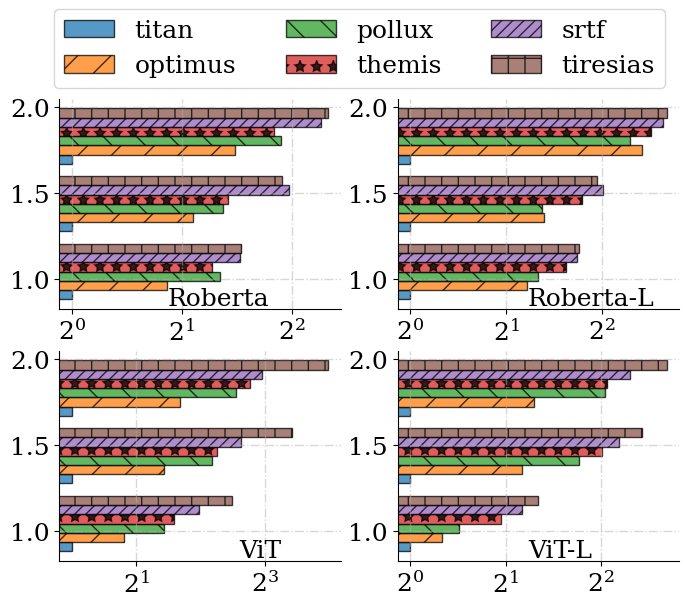

In [129]:
if True:
    template.update(
        {
            "logy": 0,
            "logx": 2,
        }
    )
    fig, axes = init_plot((2,2), grid=True, logy=template.get('logy', 0), logx=template.get('logx',2))
    model_others_list = ['Roberta', 'Roberta-L', 'ViT', 'ViT-L']
    model_name_list = ['roberta-base', 'roberta-large', 'vit', 'vit-large']
    for model_id, model_name in enumerate(model_name_list): 
#     for ax in axes: 
        ax = axes[model_id]
        x_list = [i for i in range(10)]
        y_list = [np.random.randn(1) for x in x_list]
        # ax.plot(x_list, y_list, linestyle=line_style_list[1], linewidth=template['linewidth'], color=color_list[0], \
        #     marker=marker_list[3], markersize=template['line_markersize'], markerfacecolor=color_list[1], markeredgecolor=color_list[1])
        # ax.scatter(x_list, y_list, marker=marker_list[2], s=template['scatter_markersize'])
        # info_by_method = [
        #     ['Tiresias',[1.75, 1.67, 2.87, 4.57], [0, 0, 0, 0] ],
        #     ['SRTF ', [1.74, 1.68, 1.99, 3.02], [0, 0, 0, 0] ], 
        #     ['Titan', [0.89, 1.04, 1.44, 1.88], [0, 0, 0, 0]]
        # ]



        template.update(
            {
                "norm": True, 
                "width": 1.5,
                "disable_legend": model_id!=0,
            }
        )
        plot_bar_by_method(ax, info_by_method_dict[model_name], **template)
        # ax.set_xlim(-0.5, 4)
        # ax.set_ylim(0, 1, 2)
        # ax.set_ylabel('Avg. JCT (Hour)', fontsize=template['fontsize'])
        # import pdb; pdb.set_trace() 
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # axes_list = [1.2, 3.2, 5.2, 7.2]
#         ax.set_xlabel(model_others_list[model_id], fontsize=template['fontsize'])
        text_delta = 0 if 'Roberta' in model_others_list[model_id] else 4
#         ax.text( 3.5 + text_delta, 0.7, model_others_list[model_id], fontsize=template['fontsize'], horizontalalignment='center')

        lo, hi = ax.get_xlim()
        ax.annotate(model_others_list[model_id], (hi/3, 0.5), fontsize=template['fontsize'])
        
        axes_list = [5.25, 19.25, 33.25]
        ax.set_yticks([val -0.5 for val in axes_list])
        ax.set_yticklabels(['1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
        if model_id == 0: 
            if False: 
                axes_list = [1, 5, 9, 13]
                ax.set_xticks([val + 0.5 for val in axes_list])
                ax.set_xticklabels(['0.5', '1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
            else: 
                axes_list = [5.25, 19.25, 33.25]
                ax.set_yticks([val -0.5 for val in axes_list])
                ax.set_yticklabels(['1.0', '1.5', '2.0'], fontsize=template['fontsize'], rotation=0)
#             ax.set_ylabel('Relative Workload Density', fontsize=template['fontsize'])
#     plt.legend() 
    fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
#     width * ( (len(info_by_method) - 1) // 4 + 0.5 * (len(info_by_method) - 1) % 2 ) + idx * width
    # fig.legend(fontsize=template['fontsize'], loc='upper center', ncol=3, bbox_to_anchor=(0.55, 1.05), fancybox=True, shadow=False) 
#     plt.savefig('images/e2e/jct.jpg',  bbox_inches='tight') 
    plt.savefig('images/e2e/jct.pdf',  bbox_inches='tight') 
    plt.show()

    
    
    
    

In [112]:
template

{'fontsize': 18,
 'linewidth': 6,
 'scatter_markersize': 400,
 'line_markersize': 20,
 'width': 1.5,
 'norm': True,
 'autolabel': False,
 'logy': 0,
 'logx': 2,
 'barh': True,
 'disable_legend': True}

In [ ]:
info_by_method